# Importing required modules and functions, and loading data

The training and test sets were stored in separate files. The index of each observation represents the position of the observation in the original file (i.e., the file containing all observations; features.parquet)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import os
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from model_utils import train_classifier, plot_report, compare_train_test_performance
from fastai.tabular.all import *

In [2]:
# Dowload optuna
#import sys 
#!{sys.executable} -m pip install --user optuna

# Import optuna
!export PATH="/scratch/project_2001325/evo_hyperspectral/packages:$PATH"
import optuna

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = Path("./data/matched_w_features/")

train_data = gpd.read_parquet(data_path/"train_data.parquet")
train_info = train_data.iloc[:,:20]
train_features = train_data.iloc[:,20:]

test_data = gpd.read_parquet(data_path/"test_data.parquet")
test_info = test_data.iloc[:,:20]
test_features = test_data.iloc[:,20:]

In [4]:
import geopandas as gpd
gdf = gpd.from_file("data/field_data/all_trees_w_deadwood.shp")

AttributeError: module 'geopandas' has no attribute 'from_file'

## KNN

We'll start by testing the KNN approach. We see that the KNN has troubles identifying the deadwood instances. This is likely because the proportion of deadwood observations in the training dataset is rather small and thus the neighborhood of each deadwood observations will mainly consist of observations from the other species classes.

In [5]:
# Create a classifier consisting of feature standardization, ANOVA-based feature selection, and KNN
steps = [('scaler', StandardScaler()), ('selector', SelectKBest(f_classif)), ('classifier', KNN())]
clf = Pipeline(steps)

param_grid = {'selector__k': 2**np.arange(0,9)*10,
             'classifier__n_neighbors': np.arange(1,20,4),
             'classifier__p': [1,2]}

trained_clf = train_classifier(clf, param_grid, train_features, train_info.species, n_iter = 24, n_jobs = -1)

                precision    recall  f1-score   support

         Birch       0.35      0.55      0.43       188
European aspen       0.67      0.41      0.51       281
 Norway spruce       0.46      0.44      0.45       284
    Scots pine       0.67      0.74      0.70       527
      deadwood       0.00      0.00      0.00        48

      accuracy                           0.55      1328
     macro avg       0.43      0.43      0.42      1328
  weighted avg       0.56      0.55      0.54      1328

Cohen's kappa: 0.38
Matthews correlation coefficient: 0.39


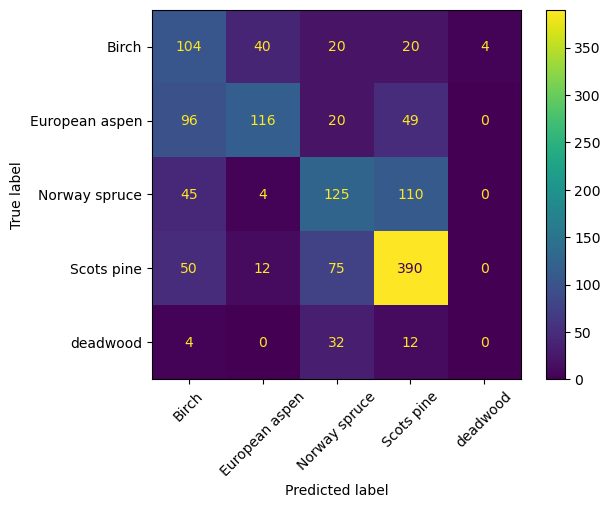

In [6]:
plot_report(test_info.species, trained_clf.predict(test_features))

## Logistic regression with L2-regularization

Next, we will train a logistic regression model with L2 regularization to classify the observations. Since some of the features are highly correlated, we will apply PCA as a preprocessing step. We'll use the first 100 principal components as features in the model.

We see that the logistic regression model also has troubles identifying the deadwood instances, although the performance in general is significantly higher.

In [27]:
steps = [('scaler', StandardScaler()), 
         ('pca', PCA(n_components = 100)),
         ('scaler2', StandardScaler()),
         ('selector', SelectKBest(f_classif)), 
         ('classifier', LogisticRegression(penalty = "l2", solver = 'liblinear', max_iter = 1000))]

clf = Pipeline(steps)

param_grid = {'selector__k': np.arange(10,101,10),
              'classifier__C': 5.0**np.arange(-5,2),
              'classifier__class_weight': ['balanced']}

trained_clf = train_classifier(clf, param_grid, train_features, train_info.species, n_iter = 24, n_jobs = -1)

                precision    recall  f1-score   support

         Birch       0.50      0.66      0.57       188
European aspen       0.84      0.78      0.81       281
 Norway spruce       0.62      0.51      0.56       284
    Scots pine       0.76      0.83      0.80       527
      deadwood       0.00      0.00      0.00        48

      accuracy                           0.70      1328
     macro avg       0.54      0.56      0.55      1328
  weighted avg       0.68      0.70      0.69      1328

Cohen's kappa: 0.58
Matthews correlation coefficient: 0.58


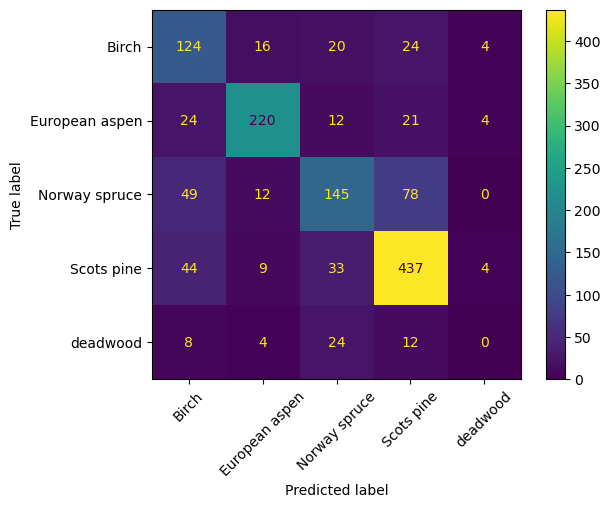

In [28]:
plot_report(test_info.species, trained_clf.predict(test_features))

### Random forest

Next, we'll experiment with random forest. We'll also inspect the feature importance based on the mean decrease in impurity metric. Tree ensemble methods are rather good at selecting the most important features, so we will not perform feature selection.

We will first subsample the data so that each class has the same number of observations. This helps classifying the minority classes (deadwood) correctly, as otherwise the optimization would mainly conside the majority classes.

In [4]:
def extract_random_subsample(label, n):
    """ Extracts n random samples with the defined label."""
    locs = np.where(train_info.species == label)[0]
    locs = np.random.choice(locs, n, replace = False)
    return train_info.iloc[locs,:], train_features.iloc[locs,:]

# Extract 176 samples from each class (176 is the number of deadwood instances)
Xs = []
ys = []
for label in train_info.species.unique():
    y, X = extract_random_subsample(label, 176)
    Xs.append(X)
    ys.append(y)
X = pd.concat(Xs)
y = pd.concat(ys)

In [21]:
steps = [('scaler', StandardScaler()),
         ('classifier', RandomForestClassifier())]

clf = Pipeline(steps)

# n_estimators, criterion, max_depth, min_samples_split, class_weight
param_grid = {'classifier__criterion' : ['gini','log_loss'],
              'classifier__min_samples_split' : 2**np.arange(1,5),
              'classifier__n_estimators' : [100, 200, 300],
              'classifier__max_depth' : np.arange(5,60,5)}

trained_clf = train_classifier(clf, param_grid, X, y.species, n_iter = 24, n_jobs = -1)

                precision    recall  f1-score   support

         Birch       0.32      0.55      0.41       188
European aspen       0.67      0.47      0.55       281
 Norway spruce       0.50      0.40      0.44       284
    Scots pine       0.72      0.74      0.73       527
      deadwood       0.38      0.33      0.36        48

      accuracy                           0.57      1328
     macro avg       0.52      0.50      0.50      1328
  weighted avg       0.59      0.57      0.57      1328

Cohen's kappa: 0.41
Matthews correlation coefficient: 0.42


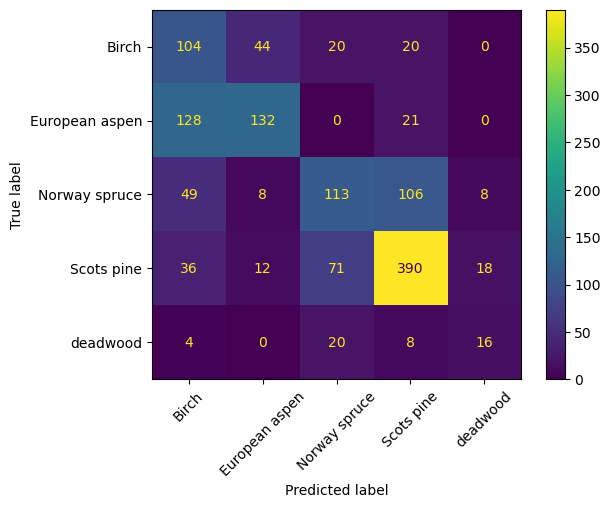

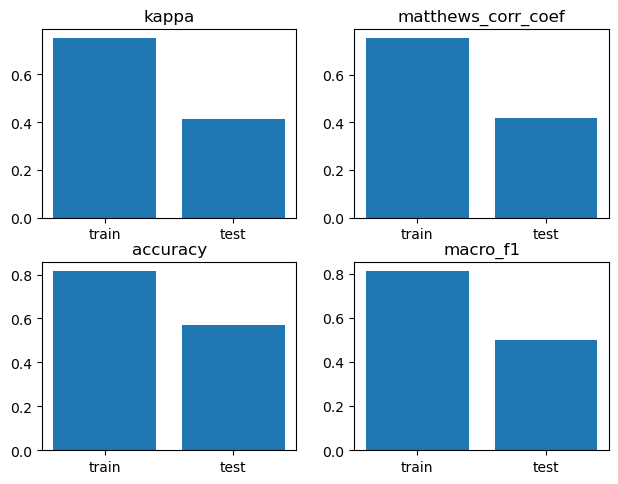

In [22]:
plot_report(test_info.species, trained_clf.predict(test_features))
compare_train_test_performance(train_info.species, trained_clf.predict(train_features), test_info.species, trained_clf.predict(test_features))

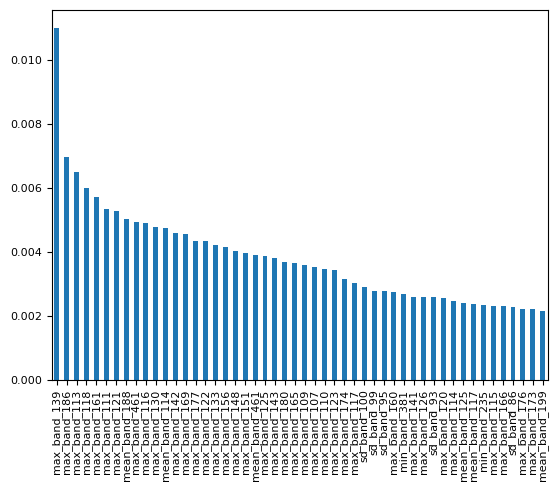

In [31]:
importances = trained_clf[1].feature_importances_
important_idx = np.argsort(importances)[::-1]
important_50 = pd.Series(importances[important_idx[:50]], index = train_features.columns[important_idx[:50]])
important_50.plot.bar(fontsize = 8)
plt.show()

### SVM with linear kernel

In [25]:
from sklearn.pipeline import Pipeline
class_weight = {'Birch': 1,
                'European aspen': 1,
                'Norway spruce': 1,
                'Scots pine': 1,
                'deadwood': 1000}
steps = [('scaler', StandardScaler()), 
         ('pca', PCA(n_components = 500)),
         ('scaler2', StandardScaler()),
         ('selector', SelectKBest(f_classif)), 
         ('classifier', LinearSVC(penalty = "l2", fit_intercept = False, max_iter = 10000, dual = "auto", class_weight = class_weight))]

clf = Pipeline(steps)
param_grid = {'selector__k': np.arange(10,501,10),
              'classifier__C': np.arange(1e-5,5,1e-5)}

trained_clf = train_classifier(clf, param_grid, train_features, train_info.species, n_iter = 8, n_jobs = -1, verbose = 3)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                precision    recall  f1-score   support

         Birch       0.54      0.64      0.59       188
European aspen       0.83      0.85      0.84       281
 Norway spruce       0.69      0.51      0.59       284
    Scots pine       0.80      0.81      0.80       527
      deadwood       0.15      0.25      0.19        48

      accuracy                           0.71      1328
     macro avg       0.60      0.61      0.60      1328
  weighted avg       0.72      0.71      0.71      1328

Cohen's kappa: 0.60
Matthews correlation coefficient: 0.61


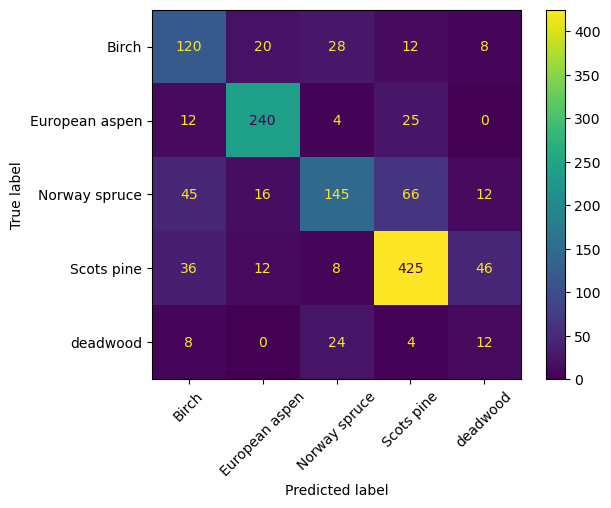

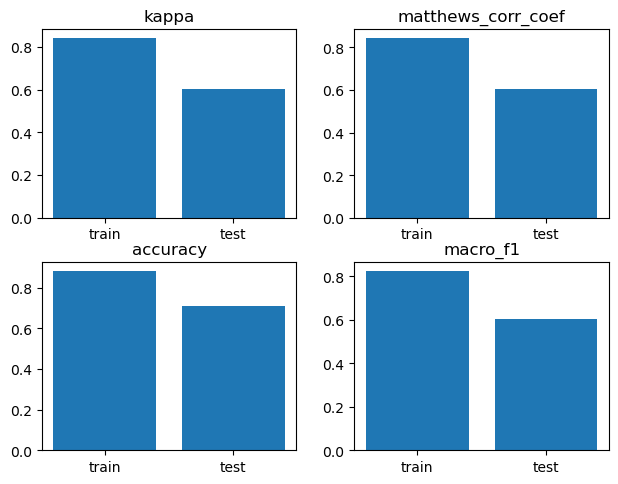

[CV 4/5] END classifier__C=0.90566, selector__k=330;, score=0.588 total time=  58.0s
[CV 4/5] END classifier__C=2.06721, selector__k=340;, score=0.582 total time= 1.1min
[CV 1/5] END classifier__C=4.56447, selector__k=50;, score=0.667 total time=   6.0s
[CV 3/5] END classifier__C=4.56447, selector__k=50;, score=0.649 total time=   5.8s
[CV 5/5] END classifier__C=0.90566, selector__k=330;, score=0.612 total time=  59.8s
[CV 5/5] END classifier__C=2.06721, selector__k=340;, score=0.639 total time= 1.2min
[CV 4/5] END classifier__C=4.56447, selector__k=50;, score=0.587 total time=   5.8s
[CV 1/5] END classifier__C=2.43854, selector__k=210;, score=0.756 total time=  14.2s
[CV 5/5] END classifier__C=2.43854, selector__k=210;, score=0.679 total time=  14.8s
[CV 3/5] END classifier__C=1.9037200000000003, selector__k=270;, score=0.729 total time=  21.9s
[CV 2/5] END classifier__C=2.06721, selector__k=340;, score=0.637 total time= 1.3min
[CV 2/5] END classifier__C=4.56447, selector__k=50;, scor

In [26]:
plot_report(test_info.species, trained_clf.predict(test_features))
compare_train_test_performance(train_info.species, trained_clf.predict(train_features), test_info.species, trained_clf.predict(test_features))

### LightGBM

In [99]:
class_weight = {'Birch': 1,
                'European aspen': 1,
                'Norway spruce': 1,
                'Scots pine': 1,
                'deadwood': 100}
params = {'max_depth' : 5,
          'learning_rate' : 0.58,
          'n_estimators' : 100,
          'class_weight' : None,
          'min_child_samples' : 12,
          'num_leaves' : 15}
clf = LGBMClassifier(metric = 'multi_logloss', objective = 'multiclass', boosting_type = "gbdt", **params)
trained_clf = clf.fit(X,y.species)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703244
[LightGBM] [Info] Number of data points in the train set: 880, number of used features: 2766
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

                precision    recall  f1-score   support

         Birch       0.33      0.49      0.39       188
European aspen       0.77      0.53      0.63       281
 Norway spruce       0.54      0.44      0.49       284
    Scots pine       0.70      0.81      0.75       527
      deadwood       0.67      0.17      0.27        48

      accuracy                           0.60      1328
     macro avg       0.60      0.49      0.50      1328
  weighted avg       0.63      0.60      0.60      1328

Cohen's kappa: 0.45
Matthews correlation coefficient: 0.45


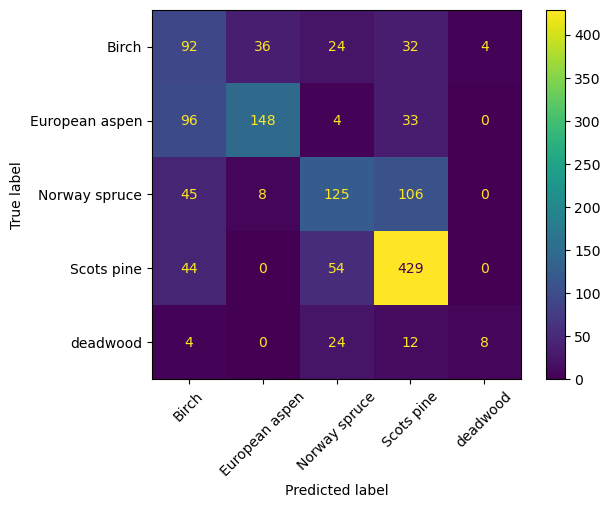

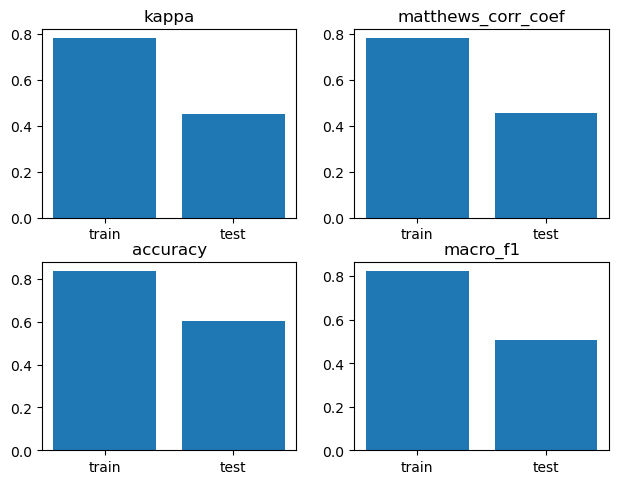

In [100]:
plot_report(test_info.species, trained_clf.predict(test_features))
compare_train_test_performance(train_info.species, trained_clf.predict(train_features), test_info.species, trained_clf.predict(test_features))

### SVM with RBF kernel

In [29]:
class_weight = {'Birch': 0.1,
                'European aspen': 0.1,
                'Norway spruce': 0.1,
                'Scots pine': 0.1,
                'deadwood': 1000}
steps = [('scaler', StandardScaler()), 
         ('pca', PCA(n_components = 500)),
         ('scaler2', StandardScaler()),
         ('selector', SelectKBest(f_classif)), 
         ('classifier', SVC())]

clf = Pipeline(steps)
              
param_grid = {'selector__k': np.arange(10,501,10),
              'classifier__C': np.arange(1e-5,5,1e-5),
              'classifier__class_weight': [class_weight]}

trained_clf = train_classifier(clf, param_grid, train_features, train_info.species, n_iter = 8, n_jobs = -1, verbose = 3)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [30]:
trained_clf

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=500)),
                ('scaler2', StandardScaler()), ('selector', SelectKBest(k=260)),
                ('classifier',
                 SVC(C=3.2234700000000003,
                     class_weight={'Birch': 0.1, 'European aspen': 0.1,
                                   'Norway spruce': 0.1, 'Scots pine': 0.1,
                                   'deadwood': 1000}))])

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

                precision    recall  f1-score   support

         Birch       0.60      0.55      0.58       188
European aspen       0.92      0.67      0.78       281
 Norway spruce       0.50      0.67      0.57       284
    Scots pine       0.76      0.83      0.79       527
      deadwood       0.00      0.00      0.00        48

      accuracy                           0.69      1328
     macro avg       0.56      0.54      0.54      1328
  weighted avg       0.69      0.69      0.68      1328

Cohen's kappa: 0.57
Matthews correlation coefficient: 0.57


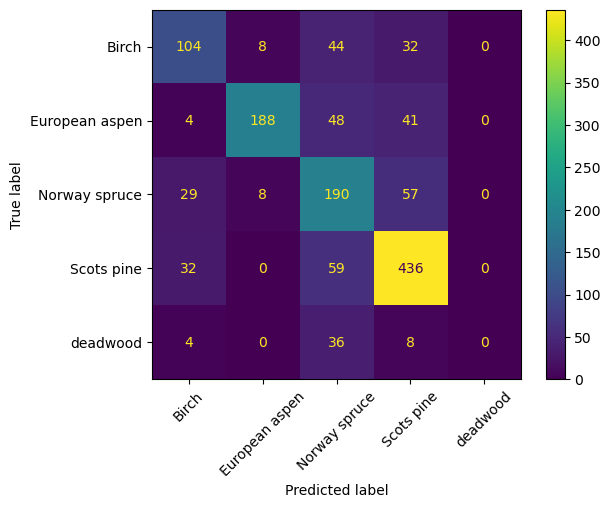

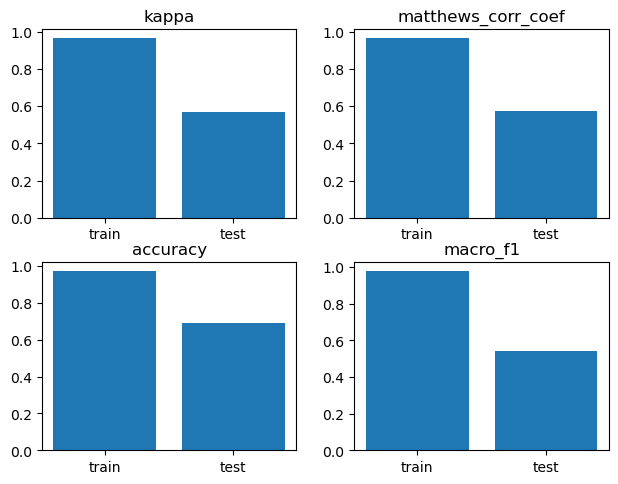

In [31]:
plot_report(test_info.species, trained_clf.predict(test_features))
compare_train_test_performance(train_info.species, trained_clf.predict(train_features), test_info.species, trained_clf.predict(test_features))

### Multi-layer perceptron

In [103]:
class_weight = {'Birch': 0.1,
                'European aspen': 0.1,
                'Norway spruce': 0.1,
                'Scots pine': 0.1,
                'deadwood': 1000}

trained_clf = MLPClassifier(hidden_layer_sizes = [50,100,100,100,100,100,100,50], verbose = True, early_stopping = True, n_iter_no_change = 20)
trained_clf.fit(train_features, train_info.species)      

Iteration 1, loss = 1.30041884
Validation score: 0.556355
Iteration 2, loss = 0.94758584
Validation score: 0.647482
Iteration 3, loss = 0.81511776
Validation score: 0.720624
Iteration 4, loss = 0.78314126
Validation score: 0.724221
Iteration 5, loss = 0.74515876
Validation score: 0.749400
Iteration 6, loss = 0.68199403
Validation score: 0.748201
Iteration 7, loss = 0.66524646
Validation score: 0.749400
Iteration 8, loss = 0.66810665
Validation score: 0.708633
Iteration 9, loss = 0.62377615
Validation score: 0.761391
Iteration 10, loss = 0.63657993
Validation score: 0.775779
Iteration 11, loss = 0.57815275
Validation score: 0.735012
Iteration 12, loss = 0.61058670
Validation score: 0.799760
Iteration 13, loss = 0.56145676
Validation score: 0.760192
Iteration 14, loss = 0.55534230
Validation score: 0.821343
Iteration 15, loss = 0.52555696
Validation score: 0.790168
Iteration 16, loss = 0.55361443
Validation score: 0.811751
Iteration 17, loss = 0.50435272
Validation score: 0.832134
Iterat

MLPClassifier(early_stopping=True,
              hidden_layer_sizes=[50, 100, 100, 100, 100, 100, 100, 50],
              n_iter_no_change=20, verbose=True)

                precision    recall  f1-score   support

         Birch       0.46      0.51      0.48       188
European aspen       0.73      0.63      0.68       281
 Norway spruce       0.51      0.47      0.49       284
    Scots pine       0.73      0.80      0.76       527
      deadwood       0.22      0.17      0.19        48

      accuracy                           0.63      1328
     macro avg       0.53      0.52      0.52      1328
  weighted avg       0.63      0.63      0.63      1328

Cohen's kappa: 0.49
Matthews correlation coefficient: 0.49


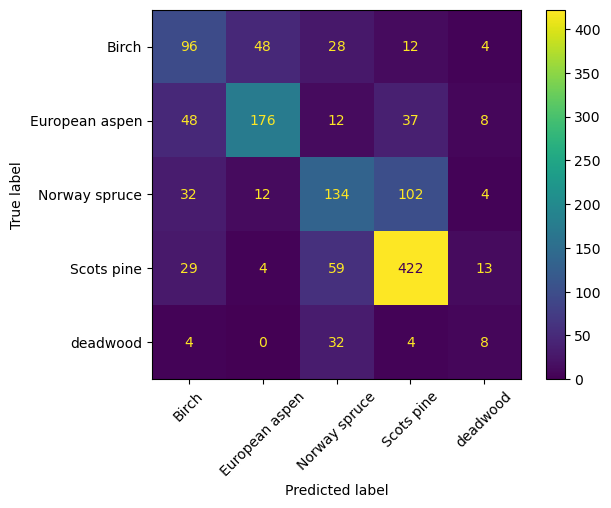

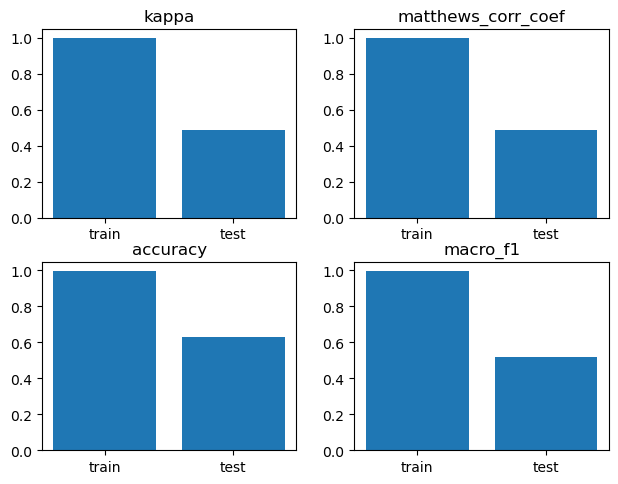

In [105]:
plot_report(test_info.species, trained_clf.predict(test_features))
compare_train_test_performance(train_info.species, trained_clf.predict(train_features), test_info.species, trained_clf.predict(test_features))

### Fastai

##### Multiclass classification

In [30]:
# Combine the training features with the targets
train_data = train_features.merge(train_info.species, left_index = True, right_index = True).sample(frac = 1, random_state = 3)
test_data = test_features.merge(test_info.species, left_index = True, right_index = True)

# Compute the feature means and standard deviations for standardization
stats = np.array([train_features.values.mean(axis = 0), train_features.values.std(axis = 0)])

# Create a dataloader for the data
dl = TabularDataLoaders.from_df(df = train_data,
                                procs = [Normalize.from_stats(*stats)],
                                y_names = ["species"],
                                y_block = CategoryBlock,
                                valid_idx = np.arange(-1667,-1))

test_dl = dl.test_dl(test_features)
                                     

epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,cohen_kappa_score,matthews_corrcoef,time
0,0.858713,0.723902,0.699083,0.740440,0.683290,0.723515,0.724140,00:02
1,0.665981,0.569429,0.768404,0.818364,0.747038,0.786222,0.786589,00:02
2,0.547383,0.469470,0.779596,0.827719,0.763082,0.816028,0.816229,00:02
3,0.483728,0.397352,0.840679,0.914278,0.813127,0.856401,0.856883,00:02
4,0.420458,0.356234,0.844143,0.915963,0.813697,0.854964,0.856350,00:02
5,0.377228,0.333659,0.869397,0.920713,0.842370,0.872293,0.872416,00:02
6,0.367099,0.301545,0.882670,0.906798,0.866683,0.879843,0.880062,00:02
7,0.330699,0.286037,0.847283,0.922404,0.818831,0.863510,0.864478,00:02
8,0.305186,0.223441,0.929671,0.947400,0.915587,0.911235,0.911463,00:02
9,0.283225,0.271010,0.879197,0.903790,0.863048,0.870283,0.870927,00:02


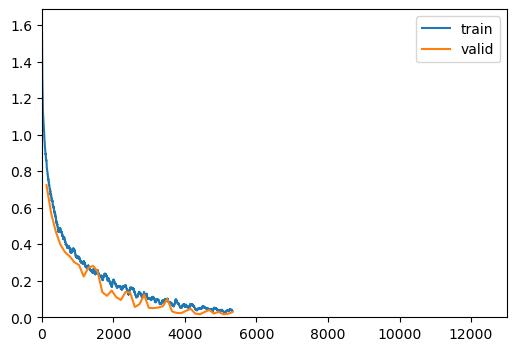

No improvement since epoch 33: early stopping


In [33]:
metrics = [F1Score(average='macro'),
           Precision(average='macro'),
           Recall(average='macro'),
           CohenKappa(),
           MatthewsCorrCoef()]
learn = tabular_learner(dl, 
                        metrics = metrics, 
                        cbs = [ShowGraphCallback(), EarlyStoppingCallback(monitor = "valid_loss",patience = 8)],
                        loss_func = CrossEntropyLossFlat(weight = torch.Tensor([1,1,1,1,1])),
                        )
                                
learn.fit_one_cycle(100)

                precision    recall  f1-score   support

         Birch       0.41      0.60      0.49       188
European aspen       0.80      0.51      0.62       281
 Norway spruce       0.55      0.52      0.54       284
    Scots pine       0.75      0.82      0.78       527
      deadwood       0.43      0.25      0.32        48

      accuracy                           0.64      1328
     macro avg       0.59      0.54      0.55      1328
  weighted avg       0.66      0.64      0.64      1328

Cohen's kappa: 0.50
Matthews correlation coefficient: 0.51


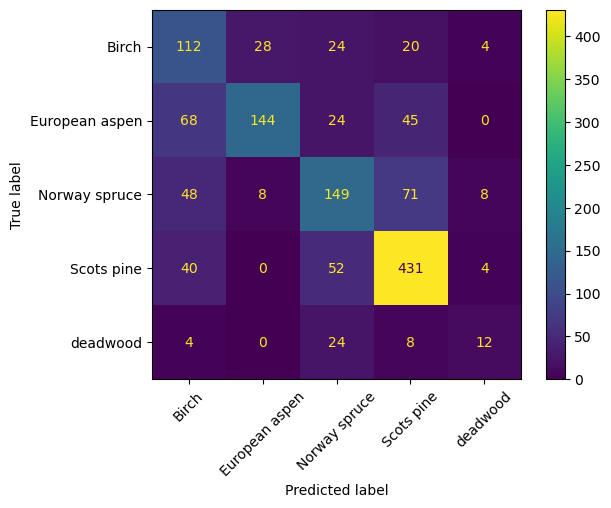

In [34]:
prob, _ = learn.get_preds(dl = test_dl)
y_hat = pd.Series(dl.vocab[np.argmax(prob, axis = 1)])
plot_report(test_data.species, y_hat)

##### Binary classification

In [27]:
# Combine the training features with the targets
train_data = train_features.merge(train_info.species, left_index = True, right_index = True).sample(frac = 1, random_state = 3)
test_data = test_features.merge(test_info.species, left_index = True, right_index = True)
train_data["species"] = train_data.species.apply(lambda x: x if x == "deadwood" else "other")
test_data["species"] = test_data.species.apply(lambda x: x if x == "deadwood" else "other")

# Compute the feature means and standard deviations for standardization
stats = np.array([train_features.values.mean(axis = 0), train_features.values.std(axis = 0)])

# Create a dataloader for the data
dl = TabularDataLoaders.from_df(df = train_data,
                                procs = [Normalize.from_stats(*stats)],
                                y_names = ["species"],
                                y_block = CategoryBlock,
                                valid_idx = np.arange(-1667,-1))

test_dl = dl.test_dl(test_features)

epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,cohen_kappa_score,matthews_corrcoef,time
0,0.358636,0.294552,0.346046,0.516376,0.729218,0.029584,0.122533,00:02
1,0.308513,0.255608,0.361263,0.517281,0.743888,0.033158,0.129841,00:02
2,0.212462,0.258560,0.360008,0.517202,0.742665,0.032846,0.129217,00:02
3,0.205526,0.230617,0.409964,0.521186,0.792787,0.048423,0.157520,00:02
4,0.228424,0.245057,0.377069,0.518360,0.759474,0.037399,0.138042,00:02
5,0.228121,0.234066,0.406980,0.520891,0.789731,0.047278,0.155600,00:02
6,0.256636,0.229592,0.406681,0.520862,0.789425,0.047166,0.155410,00:02
7,0.192322,0.191252,0.502133,0.536496,0.883557,0.106049,0.236630,00:02
8,0.175570,0.175420,0.472420,0.529940,0.856051,0.081794,0.206497,00:02
9,0.158317,0.196093,0.483615,0.532189,0.866748,0.090183,0.217303,00:02


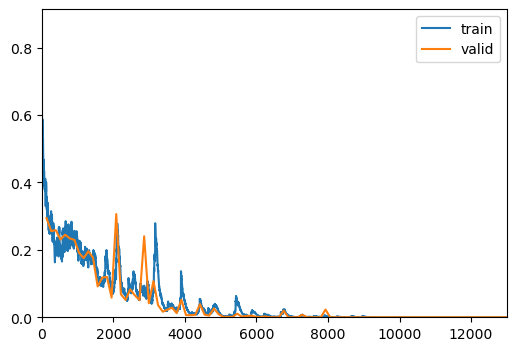

[CV 3/5] END classifier__C=0.90566, selector__k=330;, score=0.654 total time=  38.9s
[CV 4/5] END classifier__C=1.9037200000000003, selector__k=270;, score=0.632 total time=  26.5s
[CV 1/5] END classifier__C=2.1156300000000003, selector__k=80;, score=0.694 total time=   6.8s
[CV 3/5] END classifier__C=2.1156300000000003, selector__k=80;, score=0.686 total time=   6.4s
[CV 5/5] END classifier__C=2.1156300000000003, selector__k=80;, score=0.647 total time=   7.0s
[CV 2/5] END classifier__C=0.92667, selector__k=180;, score=0.674 total time=  11.6s
[CV 5/5] END classifier__C=0.92667, selector__k=180;, score=0.665 total time=  12.4s
[CV 4/5] END classifier__C=4.62029, selector__k=490;, score=0.588 total time= 2.3min
[CV 2/5] END classifier__C=0.90566, selector__k=330;, score=0.626 total time= 1.6min
[CV 4/5] END classifier__C=0.92667, selector__k=180;, score=0.638 total time=  10.4s
[CV 3/5] END classifier__C=4.62029, selector__k=490;, score=0.649 total time= 4.0min
[CV 1/5] END classifier_

In [28]:
metrics = [F1Score(average='macro'),
           Precision(average='macro'),
           Recall(average='macro'),
           CohenKappa(),
           MatthewsCorrCoef()]
learn = tabular_learner(dl, 
                        metrics = metrics, 
                        cbs = [ShowGraphCallback(), EarlyStoppingCallback(monitor = "valid_loss",patience = 8)],
                        loss_func = CrossEntropyLossFlat(weight = torch.Tensor([1e10,1])),
                        )
                                
learn.fit_one_cycle(100)

              precision    recall  f1-score   support

    deadwood       0.50      0.17      0.25        48
       other       0.97      0.99      0.98      1280

    accuracy                           0.96      1328
   macro avg       0.73      0.58      0.62      1328
weighted avg       0.95      0.96      0.96      1328

Cohen's kappa: 0.24
Matthews correlation coefficient: 0.27


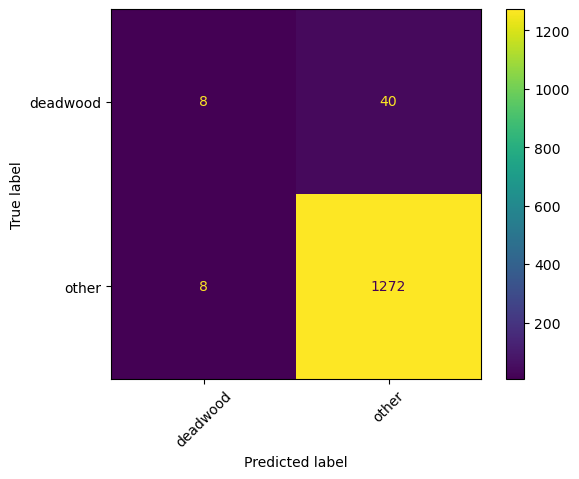

In [29]:
prob, _ = learn.get_preds(dl = test_dl)
y_hat = pd.Series(dl.vocab[np.argmax(prob, axis = 1)])
plot_report(test_data.species, y_hat)

- Test different configurations of the fastai model
- Try binary classification with large weight on deadwood